## 自注意力和位置编码
在深度学习中，经常使⽤卷积神经⽹络（CNN）或循环神经⽹络（RNN）对序列进⾏编码。想象⼀下，有了注
意⼒机制之后，我们将词元序列输⼊注意⼒池化中，以便同⼀组词元同时充当查询、键和值。具体来说，每个
查询都会关注所有的键－值对并⽣成⼀个注意⼒输出。由于查询、键和值来⾃同⼀组输⼊，因此被称为 ⾃注
意⼒（self-attention）(Lin et al., 2017, Vaswani et al., 2017)，也被称为内部注意⼒（intra-attention）(Cheng
et al., 2016, Parikh et al., 2016, Paulus et al., 2017)。本节将使⽤⾃注意⼒进⾏序列编码，以及如何使⽤序列
的顺序作为补充信息。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 自注意力


给定⼀个由词元组成的输⼊序列x1, . . . , xn，其中任意xi ∈ Rd（1 ≤ i ≤ n）。该序列的⾃注意⼒输出为⼀个⻓
度相同的序列 y1, . . . , yn，其中：  

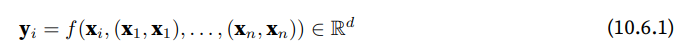

根据 (10.2.4)中定义的注意⼒汇聚函数f。下⾯的代码⽚段是基于多头注意⼒对⼀个张量完成⾃注意⼒的计
算，张量的形状为（批量⼤⼩，时间步的数⽬或词元序列的⻓度，d）。输出与输⼊的张量形状相同。



In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### 比较卷积神经网络、循环神经网络和自注意力
接下来⽐较下⾯⼏个架构，⽬标都是将由n个词元组成的序列映射到另⼀个⻓度相等的序列，其中的每个输
⼊词元或输出词元都由d维向量表⽰。具体来说，将⽐较的是卷积神经⽹络、循环神经⽹络和⾃注意⼒这⼏
个架构的计算复杂性、顺序操作和最⼤路径⻓度。请注意，顺序操作会妨碍并⾏计算，⽽任意的序列位置组
合之间的路径越短，则能更轻松地学习序列中的远距离依赖关系 (Hochreiter et al., 2001)。

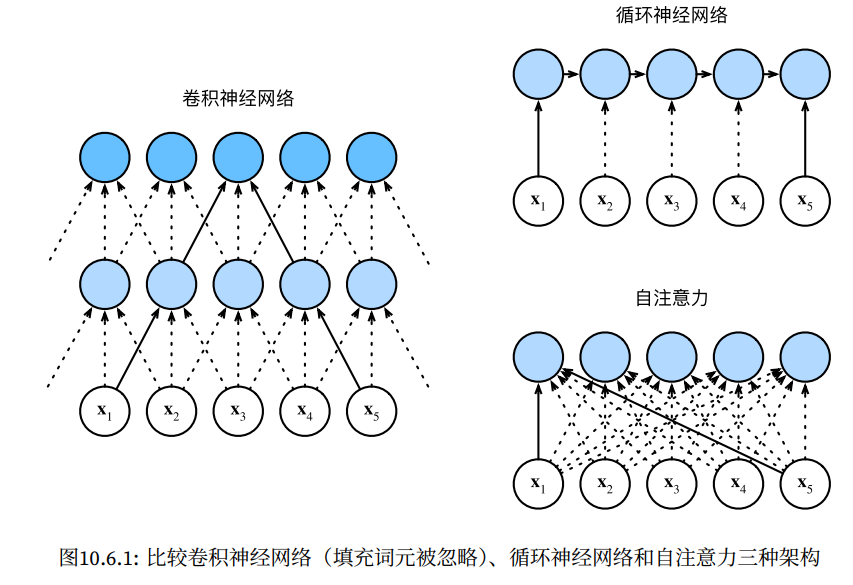

考虑⼀个卷积核⼤⼩为k的卷积层。在后⾯的章节将提供关于使⽤卷积神经⽹络处理序列的更多详细信息。⽬
前只需要知道的是，由于序列⻓度是n，输⼊和输出的通道数量都是d，所以卷积层的计算复杂度为O(knd2)。
如图10.6.1所⽰，卷积神经⽹络是分层的，因此为有O(1)个顺序操作，最⼤路径⻓度为O(n/k)。例如，x1和x5处
于图10.6.1中卷积核⼤⼩为3的双层卷积神经⽹络的感受野内。

当更新循环神经⽹络的隐状态时，d × d权重矩阵和d维隐状态的乘法计算复杂度为O(d2)。由于序列⻓度为n，
因此循环神经⽹络层的计算复杂度为O(nd2)。根据 图10.6.1，有O(n)个顺序操作⽆法并⾏化，最⼤路径⻓度
也是O(n)。

在⾃注意⼒中，查询、键和值都是n × d矩阵。考虑 (10.3.5)中缩放的”点－积“注意⼒，其中n × d矩阵乘
以d×n矩阵。之后输出的n×n矩阵乘以n×d矩阵。因此，⾃注意⼒具有O(n2d)计算复杂性。正如在 图10.6.1中
所讲，每个词元都通过⾃注意⼒直接连接到任何其他词元。因此，有O(1)个顺序操作可以并⾏计算，最⼤路
径⻓度也是O(1)。

总⽽⾔之，卷积神经⽹络和⾃注意⼒都拥有并⾏计算的优势，⽽且⾃注意⼒的最⼤路径⻓度最短。但是因为
其计算复杂度是关于序列⻓度的⼆次⽅，所以在很⻓的序列中计算会⾮常慢。

### 位置编码
在处理词元序列时，循环神经⽹络是逐个的重复地处理词元的，⽽⾃注意⼒则因为并⾏计算⽽放弃了顺序操
作。为了使⽤序列的顺序信息，通过在输⼊表⽰中添加 位置编码（positional encoding）来注⼊绝对的或相
对的位置信息。位置编码可以通过学习得到也可以直接固定得到。接下来描述的是基于正弦函数和余弦函数
的固定位置编码 (Vaswani et al., 2017)。

假设输⼊表⽰X ∈ Rn×d 包含⼀个序列中n个词元的d维嵌⼊表⽰。位置编码使⽤相同形状的位置嵌⼊矩阵
P ∈ Rn×d输出X + P，矩阵第i⾏、第2j列和2j + 1列上的元素为：

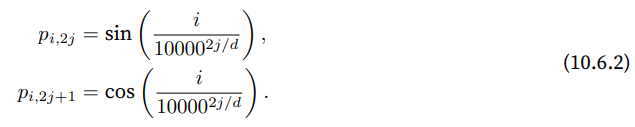

乍 ⼀ 看， 这 种 基 于 三 ⻆ 函 数 的 设 计 看 起 来 很 奇 怪。 在 解 释 这 个 设 计 之 前， 让 我 们 先 在 下 ⾯
的PositionalEncoding类中实现它。


In [4]:
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建⼀个⾜够⻓的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


在位置嵌⼊矩阵P中，⾏代表词元在序列中的位置，列代表位置编码的不同维度。从下⾯的例⼦中可以看到位
置嵌⼊矩阵的第6列和第7列的频率⾼于第8列和第9列。第6列和第7列之间的偏移量（第8列和第9列相同）是
由于正弦函数和余弦函数的交替。

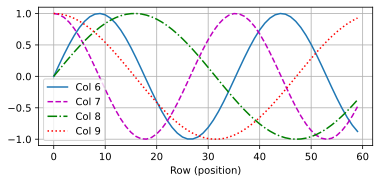

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### 绝对位置信息
为了明⽩沿着编码维度单调降低的频率与绝对位置信息的关系，让我们打印出0, 1, . . . , 7的⼆进制表⽰形式。
正如所看到的，每个数字、每两个数字和每四个数字上的⽐特值在第⼀个最低位、第⼆个最低位和第三个最
低位上分别交替。


In [6]:
for i in range(8):
    print(f'{i}的⼆进制是：{i:>03b}')


0的⼆进制是：000
1的⼆进制是：001
2的⼆进制是：010
3的⼆进制是：011
4的⼆进制是：100
5的⼆进制是：101
6的⼆进制是：110
7的⼆进制是：111


在⼆进制表⽰中，较⾼⽐特位的交替频率低于较低⽐特位，与下⾯的热图所⽰相似，只是位置编码通过使⽤
三⻆函数在编码维度上降低频率。由于输出是浮点数，因此此类连续表⽰⽐⼆进制表⽰法更节省空间。
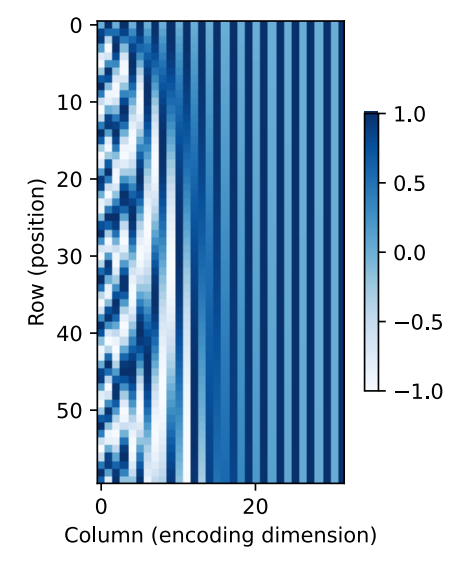

### 相对位置信息
除了捕获绝对位置信息之外，上述的位置编码还允许模型学习得到输⼊序列中相对位置信息。这是因为对于
任何确定的位置偏移δ，位置i + δ处的位置编码可以线性投影位置i处的位置编码来表⽰。

这种投影的数学解释是，令ωj = 1/100002j/d，对于任何确定的位置偏移δ，(10.6.2)中的任何⼀对
(pi,2j , pi,2j+1)都可以线性投影到 (pi+δ,2j , pi+δ,2j+1)：

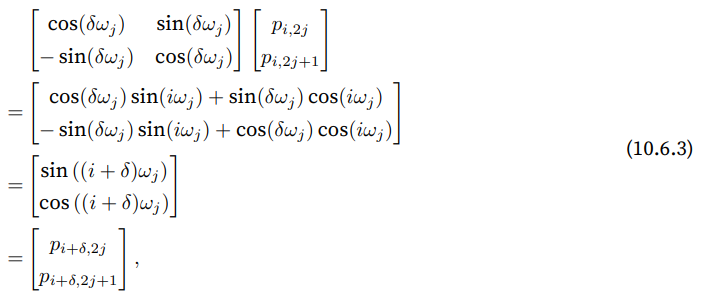

2 × 2投影矩阵不依赖于任何位置的索引i。


## 小结
* 在⾃注意⼒中，查询、键和值都来⾃同⼀组输⼊。
* 卷积神经⽹络和⾃注意⼒都拥有并⾏计算的优势，⽽且⾃注意⼒的最⼤路径⻓度最短。但是因为其计算复杂度是关于序列⻓度的⼆次⽅，所以在很⻓的序列中计算会⾮常慢。
* 为了使⽤序列的顺序信息，可以通过在输⼊表⽰中添加位置编码，来注⼊绝对的或相对的位置信息。